# Introduction

This notebook provides everything you need to use the swap test to approximate a quantum state. After the necessary functions are introduced, you're encouraged to modify target state and optimizer parameters to observe performance. I'll try to provide some reasoning for my code choices throughout.

# General imports (run this cell before everything else!)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *

# Part 1 - Generating quantum states

Before we begin, we can verify that Qiskit's quantum gate set can generate any single-qubit state starting from |0>. We do this with a u-gate, specified by angles θ and φ. 

We can visualize this as rotating |0> about the y-axis by θ radians, followed by a rotation of φ radians about the z-axis. In practice, Qiskit initializes multi-qubit states under the hood by constructing a block diagonal matrix, each block being a product of Y- and Z-rotations for the associated qubit (check the references in the readme for the source on that).

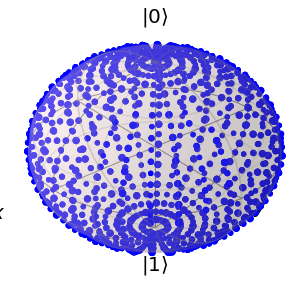

<Figure size 360x360 with 0 Axes>

In [2]:
### Verification - Does the u-gate cover the Bloch sphere? ###
# Code source: http://qutip.org/docs/latest/guide/guide-bloch.html#animating-with-the-bloch-sphere

from math import pi
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from qutip import Bloch, Qobj
%matplotlib inline

fig = plt.figure()
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['b']
sphere.point_marker = ['o']
sphere.point_size = [20, 27, 30, 40]
sphere.zlpos = [1.5, -1.5]
sphere.xlpos = [1.5, -1.5]

def animate(i, num_iters, backend):
    states = []
    for j in range(num_iters):
        qc = QuantumCircuit(1)
        qc.u((i/num_iters)*pi, (j/num_iters)*2*pi, 0, 0)
        states.append(Qobj(execute(qc, backend).result().get_statevector()))
    sphere.add_states(states, kind='point')
    sphere.make_sphere()
    return ax

# I think a random sampling until sphere coverage would have been more aesthetically pleasing, 
# but it was too time-consuming to generate. 
num_iters = 30
ani = FuncAnimation(fig, animate, fargs=(num_iters, Aer.get_backend('statevector_simulator')), frames=np.arange(num_iters))
ani.save('bloch_sphere.mp4', fps=15)

# Part 2 - Swap test implementation and state approximation

Now we introduce a proper quantum circuit. The cell below is an outline for the swap circuit, with u-gates tacked on at the front to initialize our qubits. 

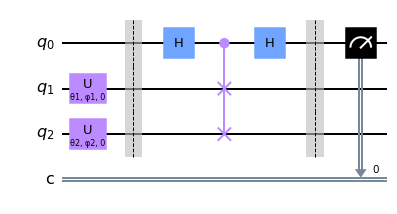

In [6]:
### The basic swap test circuit ###

from qiskit.circuit import Parameter

theta1 = Parameter('θ1')
phi1 = Parameter('φ1')
theta2 = Parameter('θ2')
phi2 = Parameter('φ2')

qc = QuantumCircuit(3, 1)
qc.u(theta1, phi1, 0, 1)
qc.u(theta2, phi2, 0, 2)
qc.barrier()
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.draw('mpl')

As mentioned in the readme, this circuit separates the original state into four components prior to measurement. Two of these components have the ancilla in the |1> state, two have it in |0>; the probability of measuring |1> is related to the inner product of the input states. If the states are parallel, we always measure 0 (useful for product states later). Otherwise, there's a nonzero chance of measuring 1. There's a vanishingly small chance of non-parallel states returning a 1 measurement after repeated trials, so we can run this circuit multiple times for verification. 

But we can do more. Collecting measurement results from running the circuit many times allows us to approximate the inner product of the two states. 

Below are the functions we'll use to run the swap test multiple times and approximate the inner product. This circuit is parametrized by the Bloch angles of our two states.

In [7]:
### Swap test functions ###

def angles_to_amplitudes(state):
    ''' Convert the Bloch angle representation of STATE to the amplitude representation. '''
    qc = QuantumCircuit(1)
    qc.u(state[0], state[1], 0, 0)
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_statevector()

def swap_test(state1, state2, backend, num_shots=1024):
    ''' Performs the swap test on STATE1 and STATE2 a total of NUM_SHOTS times. '''
    qc = QuantumCircuit(3, 1)
    qc.h(0)
    qc.u(state1[0], state1[1], 0, 1)
    qc.u(state2[0], state2[1], 0, 2)
    qc.cswap(0, 1, 2)
    qc.h(0)
    qc.measure(0, 0)
        
    job = execute(qc, backend, shots=num_shots)
    counts = job.result().get_counts()
    if '1' in counts:
        return counts['1']
    else:
        return 0
    
def inner_product_approx(state1, state2, backend, num_shots=1024):
    ''' Returns an approximation to the inner product of STATE1 and STATE2 using the swap test. '''
    counts = swap_test(state1, state2, backend, num_shots)
    return 1 - ((2 / num_shots)*counts)

def inner_product_exact(state1, state2):
    ''' Calculating the exact inner product of STATE1 and STATE2. '''
    state1 = angles_to_amplitudes(state1)
    state2 = angles_to_amplitudes(state2)
    return np.abs(np.dot(np.conjugate(state1), state2))**2

Simulators for a single qubit (relatively speaking), but we don't want to overdo it later. 1024 shots is one thing, but 4096? 16000? These numbers will slow our optimization procedure to a crawl if we have to run them every iteration. Furthermore, it's wasteful and possibly unnecessary. So for a handful of input states and target states we'll observe how many shots it takes to approximate the inner product sufficiently well.

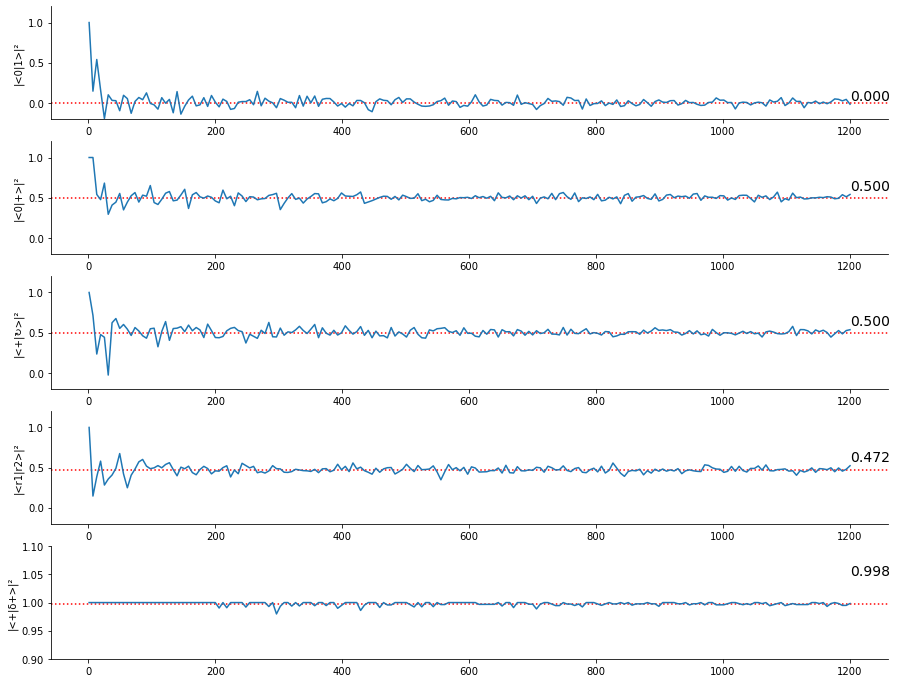

In [8]:
### Swap test convergence ###

from random import seed, uniform
from math import pi
import matplotlib.pyplot as plt
seed(42)

def swap_test_convergence(state1, state2, backend, max_shots=1200, num_trials=200, num_repeats=1):
    ''' Compute the inner product of STATE1 and STATE2 for multiple shot values. '''
    exact_ip = inner_product_exact(state1, state2)
    trials = []
    shot_range = np.linspace(1, max_shots, num_trials)
    for shot_cnt in shot_range:
        repeats = []
        for i in range(num_repeats):
            repeats.append(inner_product_approx(state1, state2, backend, num_shots=shot_cnt))
        trials.append(repeats)
    return exact_ip, shot_range, np.array(trials)

def plot_convergence(convergence_results, options):
    averaged_trials = np.mean(convergence_results[2], axis=1)
    ax = plt.subplot(options['fignum'])
    
    ylim = options['ylim']
    ypos = averaged_trials[-1] + 0.05
    ax.text(convergence_results[1][-1] + 0.5, ypos, '{0:.3f}'.format(convergence_results[0]), fontsize=14)
    ax.set_ylabel("|<"+options['states'][0]+'|'+options['states'][1]+'>|²')
    ax.set_ylim(ymin=ylim[0], ymax=ylim[1])
    ax.axhline(convergence_results[0], linestyle='dotted', color='r')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.plot(convergence_results[1], averaged_trials)
    
    return ax

qasm_backend = Aer.get_backend('qasm_simulator')
plt.figure(figsize=(15, 12))

### First test: Orthogonal states ###

zero = [0, 0]
one = [pi, 0]
results1 = swap_test_convergence(zero, one, qasm_backend)
options1 = {'fignum':511, 'ylim':(-.2, 1.2), 'states':['0', '1']}
plot_convergence(results1, options1)

### Second test: |0> and |+> ###

plus = [pi/2, 0]
results2 = swap_test_convergence(zero, plus, qasm_backend)
options2 = {'fignum':512, 'ylim':(-.2, 1.2), 'states':['0', '+']}
plot_convergence(results2, options2)

### Third test: |+> and |↻> ###

yplus = [pi/2, pi/2]
results3 = swap_test_convergence(plus, yplus, qasm_backend)
options3 = {'fignum':513, 'ylim':(-.2, 1.2), 'states':['+', '↻']}
plot_convergence(results3, options3)

### Fourth test: Two random states ###

rstate1 = [uniform(0, pi), uniform(0, 2*pi)]
rstate2 = [uniform(0, pi), uniform(0, 2*pi)]
results4 = swap_test_convergence(rstate1, rstate2, qasm_backend)
options4 = {'fignum':514, 'ylim':(-.2, 1.2), 'states': ['r1', 'r2']}
plot_convergence(results4, options4)

### Fifth test: Two states only slightly separated in theta ###

delt = .1 # Perturb theta
plus_perturbed = plus.copy()
plus_perturbed[0] += delt
results5 = swap_test_convergence(plus, plus_perturbed, qasm_backend)
options5 = {'fignum':515, 'ylim':(0.9, 1.1), 'states':['+', 'δ+']}
plot_convergence(results5, options5)

plt.show()

We see that the inner product converges to the true value pretty quickly, but there remains some fluctuations about the true value even for a large number of iterations of the swap test. We'll settle on 1024 iterations for the algorithms that follow.

The challenge now is to take our blank state and iteratively transform it until we match the target state. In this example we assume that we don't have the explicit amplitudes of our target state, so we can't use gradient descent. I decided to test a handful of global optimizers that Scipy offers to see how well we can match the target. In the next cell you can change both the target state and the initial state for our optimizers. I chose not to fiddle with the hyperparameters too much, since most seemed to match the state pretty well.

Target state was θ = 2.0088 rad, Φ = 0.1571 rad.
TESTING: Brute force search (grid search)
State minimising cost: θ = 2.0196, Φ = 0.1282 rad.
TESTING: Differential evolution
Approximate state: θ = 2.0346 rad, Φ = 0.1889 rad.
TESTING: Dual annealing search
State minimising cost: θ = 2.1396 rad, Φ = 0.2927 rad.


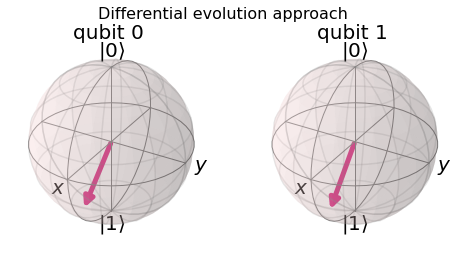

In [9]:
### Approximating a single-qubit quantum state ###

from matplotlib.pyplot import figure
from scipy.optimize import minimize, brute, differential_evolution, dual_annealing
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from random import uniform, seed
seed(42)

def cost(init_state, *args):
    return -1*inner_product_approx(init_state, args[0], args[1], args[2])

def states_for_plotting(target_state, output_state):
    qc = QuantumCircuit(2)
    qc.u(target_state[0], target_state[1], 0, 0)
    qc.u(output_state[0], output_state[1], 0, 1)
    state_backend = Aer.get_backend('statevector_simulator')
    return execute(qc, state_backend).result().get_statevector()

initial_state = [0, 0] # CHANGEME
target_state = [uniform(0, pi), uniform(0, 2*pi)] # CHANGEME
backend = Aer.get_backend('qasm_simulator')
parameter_range = ((0, pi), (0, 2*pi))
print("Target state was θ = " + '{0:.4f}'.format(target_state[0]) + " rad, Φ = " + '{0:.4f}'.format(target_state[1]) + " rad.")

### Brute force minimization ###

print("TESTING: Brute force search (grid search)")

approx_state_brute = brute(cost, ranges=parameter_range, args=(target_state, backend, 1024), Ns=50)
print("State minimising cost: θ = " + '{0:.4f}'.format(approx_state_brute[0]) + ", Φ = " + '{0:.4f}'.format(approx_state_brute[1]) + " rad.")

### Differential evolution ###

print("TESTING: Differential evolution")

approx_state_de = differential_evolution(cost, bounds=parameter_range, args=(target_state, backend, 1024))
approx_state_de = approx_state_de.get('x')
print("Approximate state: θ = " + '{0:.4f}'.format(approx_state_de[0]) + " rad, Φ = " + '{0:.4f}'.format(approx_state_de[1]) + " rad.")
statevector_de = states_for_plotting(target_state, approx_state_de)

### Dual annealing ###
print("TESTING: Dual annealing search")

approx_state_da = dual_annealing(cost, parameter_range, args=(target_state, backend, 1024))
approx_state_da = approx_state_da.get('x')
print("State minimising cost: θ = " + '{0:.4f}'.format(approx_state_da[0]) + " rad, Φ = " + '{0:.4f}'.format(approx_state_da[1]) + " rad.")

plot_bloch_multivector(statevector_de, title='Differential evolution approach')

In all cases the optimizer gets us pretty close to the target state, but the differential evolution technique is the most consistent. We expect some inaccuracies from the brute force optimizer if our grid points are far enough away from the target state parameters. 

Above you'll see a plot of the target qubit on the left and the output qubit on the right, the output coming from the differential evolution optimizer. 

# Part 3 - Using the swap test for product states 

With the single-qubit case out of the way, we next turn to what ends up being a simpler problem. Consider a multi-qubit state, but take out all the complexity: a product state where all the qubits are either |0> or |1>, like |01001>. Kind of like a quantum bit string. 

Thankfully for us, the swap test proposed by Buhrman et al. extends to multi-qubit states, we just need to be more careful when applying our controlled-swap gates.

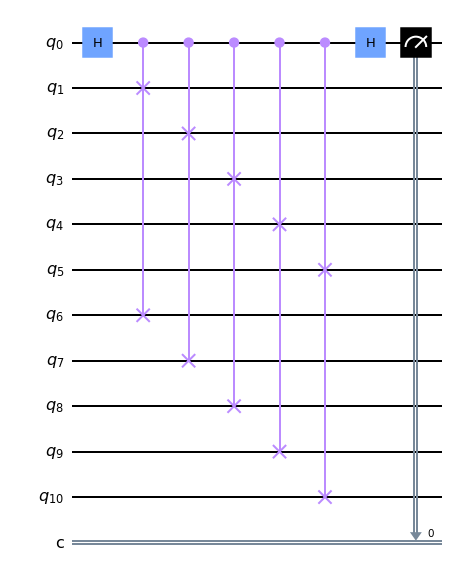

In [10]:
### Constructing a multi-qubit swap circuit ###

state_size = 5
qc = QuantumCircuit(2*state_size + 1, 1)
qc.h(0)
for i in range(1, state_size + 1):
    qc.cswap(0, i, i + state_size)
qc.h(0)
qc.measure(0, 0)
qc.draw('mpl')

This circuit performs the same function as in the single-qubit case, except we now apply a controlled-swap gate on a qubit-by-qubit basis. If you compute the measurement probabilities for the ancilla qubit, you'll find the same expression as the single-qubit swap test.

Since we're dealing with a simple kind of product state, brute force is a valid option. We search through all possible bit strings until we find a match. If our swap test returns a 1 in N runs of the swap test circuit, we'll know that one of the qubits is incorrectly set. There's a vanishingly small chance that the swap test will return a 0 for several thousand runs.

In the cell below, we represent our multi-qubit states with tuples containing the binary representation of our states (first qubit is the last element). 

In [11]:
from itertools import product

def bitlist2int(bit_list):
    s = map(str, bit_list)
    s = ''.join(s)
    return int(s, base=2)

# Swap test for multiple qubits
def swap_test_mq(state1, state2, backend, num_shots=1024):
    n = len(state1)
    q = QuantumRegister(2*n+1)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    state1_reg = np.zeros(2**n)
    state1_reg[bitlist2int(state1)] = 1
    state2_reg = np.zeros(2**n)
    state2_reg[bitlist2int(state2)] = 1
    
    qc.initialize(state1_reg, q[1:n+1])
    qc.initialize(state2_reg, q[n+1:])
    qc.h(0)
    for i in range(1, n+1):
        qc.cswap(0, i, i+n)
    qc.h(0)
    qc.measure(0, 0)
    
    job = execute(qc, backend, shots=num_shots)
    counts = job.result().get_counts()
    if '1' in counts:
        return (counts['1'] != 0)
    else:
        return 0

qasm_backend = Aer.get_backend('qasm_simulator')
num_shots=128
def grid_search(target_state, backend, num_shots):
    bitstrings = product([0, 1], repeat=len(target_state))
    for state in bitstrings:
        if swap_test_mq(state, target_state, backend, num_shots) == 0:
            return state
    return "Sorry nothing"

target_state = (0, 1, 1, 0) # CHANGEME 
output_state = grid_search(target_state, qasm_backend, num_shots=128)
print(''.join(map(str, output_state)))

0110


It's less trivial to give a good visualization for multi-qubit states, and in any case there's less to see, since we're dealing with very simple product states. I suspect the situation would be different if you allowed the individual qubits to achieve arbitrary superpositions of |0> and |1>; you could extend the single-qubit case to this case by using a global optimization procedure with parameters for each qubit. Something to look into.